 Data Preparation

Load Data:

In [1]:
import pandas as pd

df = pd.read_parquet("../data/MachineLearningRating_v3.parquet")


Handle Missing Values:

In [2]:
# Drop columns with too many missing values or impute
df = df.dropna(subset=["TotalClaims", "TotalPremium"])  # for target variables
df = df.fillna(df.median(numeric_only=True))  # simple imputation


Filter for Claim Severity Model:

In [3]:
df_claims = df[df['TotalClaims'] > 0].copy()


 Encode Categorical Variables:

In [4]:
df_encoded = pd.get_dummies(df_claims, drop_first=True)


Train-Test Split:

In [5]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=["TotalClaims", "TotalPremium"])
y = df_encoded["TotalClaims"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


 Modeling Techniques

Linear Regression:

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Impute missing values in X_train and X_test
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_imputed, y_train)
y_pred_lr = lr.predict(X_test_imputed)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)


C:\Users\try\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['NumberOfVehiclesInFleet']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\try\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['NumberOfVehiclesInFleet']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Random Forest:

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)


XGBoost:

In [15]:
%pip install xgboost
import xgboost as xgb

xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)


Defaulting to user installation because normal site-packages is not writeable
  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.2-py3-none-win_amd64.whl (150.0 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Model Interpretability (SHAP)

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.3 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.3 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.3 kB ? eta -:--:--
   -------------------------------------- 545.3/545.3 kB 412.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 558.9 kB/s eta 0:00:05
   ------- -------------------------------- 0.5/2.8 MB 5


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\try\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


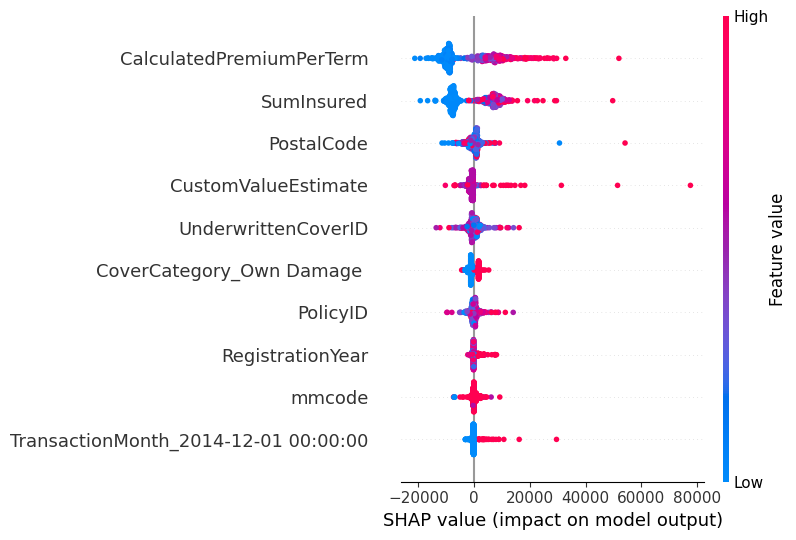

In [17]:
%pip install shap
import shap

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, max_display=10)


Predicting Claim Occurrence (Classification Model)

a. Prepare Data:

In [18]:
df_class = df.copy()
df_class["HasClaim"] = (df_class["TotalClaims"] > 0).astype(int)
df_class = pd.get_dummies(df_class, drop_first=True)


b. Train-Test Split:

In [19]:
X = df_class.drop(columns=["HasClaim", "TotalClaims", "TotalPremium"])
y = df_class["HasClaim"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


c. XGBoost Classification:

In [ ]:
xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred_class = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred_class))


 Bonus: Premium Optimization Formula


In [ ]:
# Conceptual premium = (probability of claim) * (expected severity) + expenses + margin
prob_claim = xgb_clf.predict_proba(X_test)[:, 1]
severity_pred = xgb_model.predict(X_test)
optimized_premium = prob_claim * severity_pred + 500  # add expense/margin
